# Part 3: Compression

In [1]:
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
seed = 0
np.random.seed(seed)
import tensorflow as tf
tf.random.set_seed(seed)
#import os
#os.environ['PATH'] = '/opt/Xilinx/Vivado/2019.2/bin:' + os.environ['PATH']
# for this tutorial we wont be actually running Vivado, so I have commented these lines out
#     but if you want to look into actually running on an FPGA then simply uncomment these lines

## Fetch the jet tagging dataset from Open ML

In [2]:
X_train_val = np.load('X_train_val.npy')
X_test = np.load('X_test.npy')
y_train_val = np.load('y_train_val.npy')
y_test = np.load('y_test.npy')
classes = np.load('classes.npy', allow_pickle=True)

## Now construct a model
We'll use the same architecture as in part 1: 3 hidden layers with 64, then 32, then 32 neurons. Each layer will use `relu` activation.
Add an output layer with 5 neurons (one for each class), then finish with Softmax activation.

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from callbacks import all_callbacks

In [4]:
model = Sequential()
model.add(Dense(64, input_shape=(16,), name='fc1', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu1'))
model.add(Dense(32, name='fc2', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu2'))
model.add(Dense(32, name='fc3', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu3'))
model.add(Dense(5, name='output', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='softmax', name='softmax'))

2022-07-26 21:02:27.474108: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Train sparse
This time we'll use the Tensorflow model optimization sparsity to train a sparse model (forcing many weights to '0'). In this instance, the target sparsity is 75%

In [5]:
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning
pruning_params = {"pruning_schedule" : pruning_schedule.ConstantSparsity(0.75, begin_step=2000, frequency=100)}
model = prune.prune_low_magnitude(model, **pruning_params)

/Users/drankin/miniconda3/envs/ml-latest/lib/python3.8/site-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:212: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  mask = self.add_variable(
/Users/drankin/miniconda3/envs/ml-latest/lib/python3.8/site-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:219: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  threshold = self.add_variable(
/Users/drankin/miniconda3/envs/ml-latest/lib/python3.8/site-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:233: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  self.pruning_step = self.add_variable(


## Train the model
We'll use the same settings as the model for part 1: Adam optimizer with categorical crossentropy loss.
The callbacks will decay the learning rate and save the model into a directory 'model_2'
The model isn't very complex, so this should just take a few minutes even on the CPU.
If you've restarted the notebook kernel after training once, set `train = False` to load the trained model rather than training again.

In [6]:
train = True
if train:
    adam = Adam(lr=0.0001)
    model.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])
    callbacks = all_callbacks(stop_patience = 1000,
                              lr_factor = 0.5,
                              lr_patience = 10,
                              lr_epsilon = 0.000001,
                              lr_cooldown = 2,
                              lr_minimum = 0.0000001,
                              outputDir = 'model_2')
    callbacks.callbacks.append(pruning_callbacks.UpdatePruningStep())
    model.fit(X_train_val, y_train_val, batch_size=1024,
              epochs=30, validation_split=0.25, shuffle=True,
              callbacks = callbacks.callbacks)
    # Save the model again but with the pruning 'stripped' to use the regular layer types
    model = strip_pruning(model)
    model.save('model_2/KERAS_check_best_model.h5')
else:
    from tensorflow.keras.models import load_model
    model = load_model('model_2/KERAS_check_best_model.h5')

/Users/drankin/miniconda3/envs/ml-latest/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/30
464/487 [===========================>..] - ETA: 0s - loss: 1.3388 - accuracy: 0.5105
***callbacks***
saving losses to model_2/losses.log

Epoch 1: val_loss improved from inf to 1.12515, saving model to model_2/KERAS_check_best_model.h5

Epoch 1: val_loss improved from inf to 1.12515, saving model to model_2/KERAS_check_best_model_weights.h5

Epoch 1: saving model to model_2/KERAS_check_model_last.h5

Epoch 1: saving model to model_2/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 4s 3ms/step - loss: 1.3290 - accuracy: 0.5161 - val_loss: 1.1252 - val_accuracy: 0.6363 - lr: 1.0000e-04
Epoch 2/30
472/487 [============================>.] - ETA: 0s - loss: 1.0568 - accuracy: 0.6661
***callbacks***
saving losses to model_2/losses.log

Epoch 2: val_loss improved from 1.12515 to 1.00706, saving model to model_2/KERAS_check_best_model.h5

Epoch 2: val_loss improved from 1.12515 to 1.00706, saving model to model_2/KERAS_check_best_mod


Epoch 13: saving model to model_2/KERAS_check_model_last.h5

Epoch 13: saving model to model_2/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 1s 2ms/step - loss: 0.8220 - accuracy: 0.7263 - val_loss: 0.8222 - val_accuracy: 0.7271 - lr: 1.0000e-04
Epoch 14/30
481/487 [============================>.] - ETA: 0s - loss: 0.8151 - accuracy: 0.7282
***callbacks***
saving losses to model_2/losses.log

Epoch 14: val_loss improved from 0.82223 to 0.81565, saving model to model_2/KERAS_check_best_model.h5

Epoch 14: val_loss improved from 0.82223 to 0.81565, saving model to model_2/KERAS_check_best_model_weights.h5

Epoch 14: saving model to model_2/KERAS_check_model_last.h5

Epoch 14: saving model to model_2/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 1s 2ms/step - loss: 0.8150 - accuracy: 0.7282 - val_loss: 0.8157 - val_accuracy: 0.7286 - lr: 1.0000e-04
Epoch 15/30
467/487 [==============

Epoch 26/30
478/487 [============================>.] - ETA: 0s - loss: 0.7651 - accuracy: 0.7421
***callbacks***
saving losses to model_2/losses.log

Epoch 26: val_loss improved from 0.77119 to 0.76868, saving model to model_2/KERAS_check_best_model.h5

Epoch 26: val_loss improved from 0.77119 to 0.76868, saving model to model_2/KERAS_check_best_model_weights.h5

Epoch 26: saving model to model_2/KERAS_check_model_last.h5

Epoch 26: saving model to model_2/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 1s 2ms/step - loss: 0.7653 - accuracy: 0.7420 - val_loss: 0.7687 - val_accuracy: 0.7416 - lr: 1.0000e-04
Epoch 27/30
470/487 [===========================>..] - ETA: 0s - loss: 0.7633 - accuracy: 0.7428
***callbacks***
saving losses to model_2/losses.log

Epoch 27: val_loss improved from 0.76868 to 0.76654, saving model to model_2/KERAS_check_best_model.h5

Epoch 27: val_loss improved from 0.76868 to 0.76654, saving model to model_2/KERA

## Check sparsity
Make a quick check that the model was indeed trained sparse. We'll just make a histogram of the weights of the 1st layer, and hopefully observe a large peak in the bin containing '0'. Note logarithmic y axis.

% of zeros = 0.75


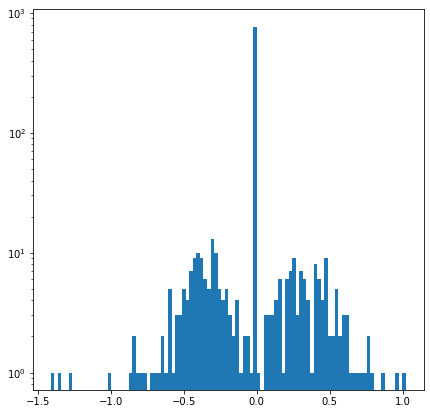

In [7]:
w = model.layers[0].weights[0].numpy()
h, b = np.histogram(w, bins=100)
plt.figure(figsize=(7,7))
plt.bar(b[:-1], h, width=b[1]-b[0])
plt.semilogy()
print('% of zeros = {}'.format(np.sum(w==0)/np.size(w)))

## Check performance
How does this 75% sparse model compare against the unpruned model? Let's report the accuracy and make a ROC curve. The pruned model is shown with solid lines, the unpruned model from part 1 is shown with dashed lines.
**Make sure you've trained the model from part 1**

5188/5188 [==============================] - 3s 541us/step
Accuracy unpruned: 0.7502650602409638
Accuracy pruned:   0.7430722891566265


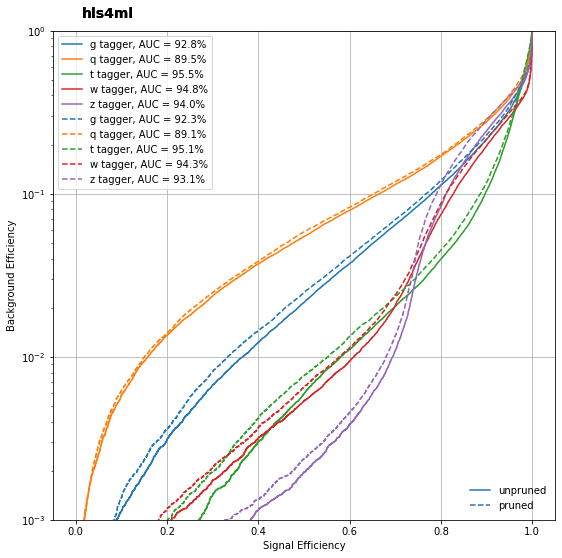

In [8]:
import plotting
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model
model_ref = load_model('model_1/KERAS_check_best_model.h5')

y_ref = model_ref.predict(X_test)
y_prune = model.predict(X_test)

print("Accuracy unpruned: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_ref, axis=1))))
print("Accuracy pruned:   {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_prune, axis=1))))

fig, ax = plt.subplots(figsize=(9, 9))
_ = plotting.makeRoc(y_test, y_ref, classes)
plt.gca().set_prop_cycle(None) # reset the colors
_ = plotting.makeRoc(y_test, y_prune, classes, linestyle='--')

from matplotlib.lines import Line2D
lines = [Line2D([0], [0], ls='-'),
         Line2D([0], [0], ls='--')]
from matplotlib.legend import Legend
leg = Legend(ax, lines, labels=['unpruned', 'pruned'],
            loc='lower right', frameon=False)
ax.add_artist(leg)

In [9]:
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning
pruning_params = {"pruning_schedule" : pruning_schedule.ConstantSparsity(0.95, begin_step=2000, frequency=100)}
model = prune.prune_low_magnitude(model, **pruning_params)

/Users/drankin/miniconda3/envs/ml-latest/lib/python3.8/site-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:212: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  mask = self.add_variable(
/Users/drankin/miniconda3/envs/ml-latest/lib/python3.8/site-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:219: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  threshold = self.add_variable(
/Users/drankin/miniconda3/envs/ml-latest/lib/python3.8/site-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:233: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  self.pruning_step = self.add_variable(


## Train the model
We'll use the same settings as the model for part 1: Adam optimizer with categorical crossentropy loss.
The callbacks will decay the learning rate and save the model into a directory 'model_2'
The model isn't very complex, so this should just take a few minutes even on the CPU.
If you've restarted the notebook kernel after training once, set `train = False` to load the trained model rather than training again.

In [10]:
train = True
if train:
    adam = Adam(lr=0.0001)
    model.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])
    callbacks = all_callbacks(stop_patience = 1000,
                              lr_factor = 0.5,
                              lr_patience = 10,
                              lr_epsilon = 0.000001,
                              lr_cooldown = 2,
                              lr_minimum = 0.0000001,
                              outputDir = 'model_3')
    callbacks.callbacks.append(pruning_callbacks.UpdatePruningStep())
    model.fit(X_train_val, y_train_val, batch_size=1024,
              epochs=30, validation_split=0.25, shuffle=True,
              callbacks = callbacks.callbacks)
    # Save the model again but with the pruning 'stripped' to use the regular layer types
    model = strip_pruning(model)
    model.save('model_3/KERAS_check_best_model.h5')
else:
    from tensorflow.keras.models import load_model
    model = load_model('model_3/KERAS_check_best_model.h5')

Epoch 1/30


/Users/drankin/miniconda3/envs/ml-latest/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


484/487 [============================>.] - ETA: 0s - loss: 0.7539 - accuracy: 0.7458
***callbacks***
saving losses to model_3/losses.log

Epoch 1: val_loss improved from inf to 0.75636, saving model to model_3/KERAS_check_best_model.h5

Epoch 1: val_loss improved from inf to 0.75636, saving model to model_3/KERAS_check_best_model_weights.h5

Epoch 1: saving model to model_3/KERAS_check_model_last.h5

Epoch 1: saving model to model_3/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 3s 3ms/step - loss: 0.7538 - accuracy: 0.7459 - val_loss: 0.7564 - val_accuracy: 0.7457 - lr: 1.0000e-04
Epoch 2/30
481/487 [============================>.] - ETA: 0s - loss: 0.7502 - accuracy: 0.7470
***callbacks***
saving losses to model_3/losses.log

Epoch 2: val_loss improved from 0.75636 to 0.75299, saving model to model_3/KERAS_check_best_model.h5

Epoch 2: val_loss improved from 0.75636 to 0.75299, saving model to model_3/KERAS_check_best_model_weights.


Epoch 14: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

***callbacks end***

487/487 [==============================] - 1s 3ms/step - loss: 1.0248 - accuracy: 0.5914 - val_loss: 1.0214 - val_accuracy: 0.5893 - lr: 1.0000e-04
Epoch 15/30
482/487 [============================>.] - ETA: 0s - loss: 1.0160 - accuracy: 0.5920
***callbacks***
saving losses to model_3/losses.log

Epoch 15: val_loss did not improve from 0.74776

Epoch 15: val_loss did not improve from 0.74776

Epoch 15: saving model to model_3/KERAS_check_model_last.h5

Epoch 15: saving model to model_3/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 1s 2ms/step - loss: 1.0161 - accuracy: 0.5919 - val_loss: 1.0156 - val_accuracy: 0.5896 - lr: 5.0000e-05
Epoch 16/30
487/487 [==============================] - ETA: 0s - loss: 1.0104 - accuracy: 0.5923
***callbacks***
saving losses to model_3/losses.log

Epoch 16: val_loss did not improve from 0.74776

Epoch 


Epoch 29: val_loss did not improve from 0.74776

Epoch 29: saving model to model_3/KERAS_check_model_last.h5

Epoch 29: saving model to model_3/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 1s 3ms/step - loss: 0.9549 - accuracy: 0.6031 - val_loss: 0.9563 - val_accuracy: 0.6018 - lr: 2.5000e-05
Epoch 30/30
469/487 [===========================>..] - ETA: 0s - loss: 0.9527 - accuracy: 0.6047
***callbacks***
saving losses to model_3/losses.log

Epoch 30: val_loss did not improve from 0.74776

Epoch 30: val_loss did not improve from 0.74776

Epoch 30: saving model to model_3/KERAS_check_model_last.h5

Epoch 30: saving model to model_3/KERAS_check_model_last_weights.h5

Epoch 30: saving model to model_3/KERAS_check_model_epoch30.h5

***callbacks end***

487/487 [==============================] - 1s 3ms/step - loss: 0.9527 - accuracy: 0.6047 - val_loss: 0.9541 - val_accuracy: 0.6034 - lr: 2.5000e-05


## Check sparsity
Make a quick check that the model was indeed trained sparse. We'll just make a histogram of the weights of the 1st layer, and hopefully observe a large peak in the bin containing '0'. Note logarithmic y axis.

% of zeros = 0.9501953125


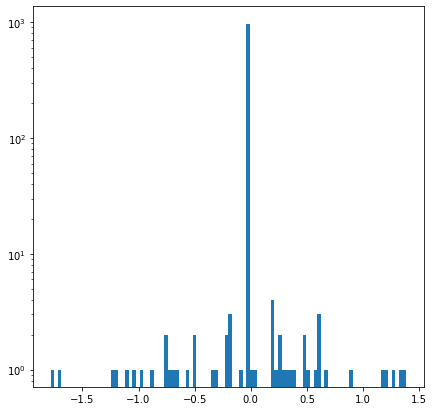

In [11]:
w = model.layers[0].weights[0].numpy()
h, b = np.histogram(w, bins=100)
plt.figure(figsize=(7,7))
plt.bar(b[:-1], h, width=b[1]-b[0])
plt.semilogy()
print('% of zeros = {}'.format(np.sum(w==0)/np.size(w)))

## Check performance
How does this 75% sparse model compare against the unpruned model? Let's report the accuracy and make a ROC curve. The pruned model is shown with solid lines, the unpruned model from part 1 is shown with dashed lines.
**Make sure you've trained the model from part 1**

5188/5188 [==============================] - 3s 585us/step
Accuracy unpruned:     0.7502650602409638
Accuracy pruned (75%): 0.7430722891566265
Accuracy pruned (95%): 0.6046626506024096


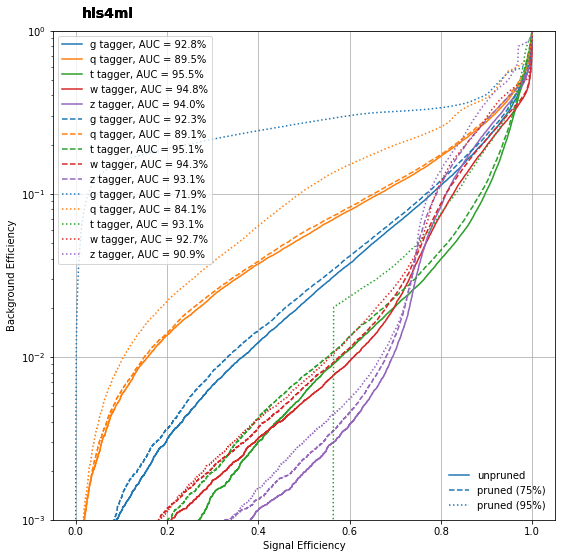

In [13]:
import plotting
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model
model_ref = load_model('model_1/KERAS_check_best_model.h5')
model_prune75 = load_model('model_2/KERAS_check_best_model.h5')

y_ref = model_ref.predict(X_test)
y_prune75 = model_prune75.predict(X_test)
y_prune95 = model.predict(X_test)

print("Accuracy unpruned:     {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_ref, axis=1))))
print("Accuracy pruned (75%): {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_prune75, axis=1))))
print("Accuracy pruned (95%): {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_prune95, axis=1))))

fig, ax = plt.subplots(figsize=(9, 9))
_ = plotting.makeRoc(y_test, y_ref, classes)
plt.gca().set_prop_cycle(None) # reset the colors
_ = plotting.makeRoc(y_test, y_prune75, classes, linestyle='--')
plt.gca().set_prop_cycle(None) # reset the colors
_ = plotting.makeRoc(y_test, y_prune95, classes, linestyle=':')

from matplotlib.lines import Line2D
lines = [Line2D([0], [0], ls='-'),
         Line2D([0], [0], ls='--'),
         Line2D([0], [0], ls=':')]
from matplotlib.legend import Legend
leg = Legend(ax, lines, labels=['unpruned', 'pruned (75%)', 'pruned (95%)'],
            loc='lower right', frameon=False)
ax.add_artist(leg)

# Convert the model to FPGA firmware with hls4ml
Let's use the default configuration: `ap_fixed<16,6>` precision everywhere and `ReuseFactor=1`, so we can compare with the part 1 model. We need to use `strip_pruning` to change the layer types back to their originals.

**The synthesis will take a while**

While the C-Synthesis is running, we can monitor the progress looking at the log file by opening a terminal from the notebook home, and executing:

`tail -f model_2/hls4ml_prj/vivado_hls.log`

In [ ]:
import hls4ml

config = hls4ml.utils.config_from_keras_model(model, granularity='model')
print(config)
hls_model = hls4ml.converters.convert_from_keras_model(model,
                                                       hls_config=config,
                                                       output_dir='model_2/hls4ml_prj',
                                                       part='xcu250-figd2104-2L-e')
hls_model.compile()
hls_model.build(csim=False)

## Check the reports
Print out the reports generated by Vivado HLS. Pay attention to the Utilization Estimates' section in particular this time.

In [ ]:
hls4ml.report.read_vivado_report('model_2/hls4ml_prj/')

Print the report for the model trained in part 1. Remember these models have the same architecture, but the model in this section was trained using the sparsity API from tensorflow_model_optimization. Notice how the resource usage had dramatically reduced (particularly the DSPs). When Vivado HLS notices an operation like `y = 0 * x` it can avoid placing a DSP for that operation. The impact of this is biggest when `ReuseFactor = 1`, but still applies at higher reuse as well. **Note you need to have trained and synthesized the model from part 1**

In [ ]:
hls4ml.report.read_vivado_report('model_1/hls4ml_prj')